In [109]:
import numpy as np
import pandas as pd
import os
import csv
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression as LR
from sklearn.metrics import mean_squared_error as MSE
import time

In [110]:
freq=60
file_path = './训练集与测试集数据'
train_data_path = os.path.join(file_path, 'train_data_{0}.csv'.format(str(freq)))
val_data_path= os.path.join(file_path, 'val_data_{0}.csv'.format(str(freq)))
train_data_pd = pd.read_csv(train_data_path,encoding="gbk")
val_data_pd = pd.read_csv(val_data_path,encoding="gbk")
print (train_data_pd)

      name       MET  speed    mean      sd     min     max    10th    25th  \
0      乔金英  4.500000      2  1.0105  0.0967  0.7925  1.4301  0.9032  0.9364   
1      乔金英  4.166667      2  1.0129  0.1036  0.7152  1.3600  0.8969  0.9312   
2      乔金英  4.466667      3  1.0591  0.1641  0.6688  1.6669  0.8532  0.9365   
3      乔金英  4.483333      3  1.0750  0.1790  0.6608  1.7861  0.8534  0.9394   
4      乔金英  4.733333      4  1.0848  0.1637  0.6237  1.5906  0.8840  0.9673   
...    ...       ...    ...     ...     ...     ...     ...     ...     ...   
1115  龚兴广2  6.616667      7  1.2954  0.7956  0.1243  3.1906  0.5234  0.6684   
1116  龚兴广2  7.300000      8  1.3821  0.8335  0.1893  3.7131  0.5939  0.7397   
1117  龚兴广2  7.333333      8  1.3745  0.8195  0.1815  3.4649  0.5819  0.7517   
1118  龚兴广2  7.950000      9  1.4035  0.8506  0.1862  3.6185  0.6063  0.7583   
1119  龚兴广2  8.216667      9  1.4131  0.8380  0.0960  3.7785  0.6038  0.7969   

        50th    75th    90th  
0     0.9874  1.0817

In [111]:
X_train = train_data_pd[['mean', 'sd', 'min', 'max', '10th', '25th', '50th', '75th','90th']]
Y_train = train_data_pd[['MET']]
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_val = val_data_pd[['mean',  'sd', 'min', 'max', '10th', '25th', '50th', '75th','90th']]
Y_val = val_data_pd[['MET']]
X_val = np.array(X_val)
Y_val = np.array(Y_val)
print(X_train)

[[1.0105 0.0967 0.7925 ... 0.9874 1.0817 1.1494]
 [1.0129 0.1036 0.7152 ... 0.9894 1.0876 1.1638]
 [1.0591 0.1641 0.6688 ... 1.0407 1.1861 1.2911]
 ...
 [1.3745 0.8195 0.1815 ... 1.0558 1.9895 2.7801]
 [1.4035 0.8506 0.1862 ... 1.0644 1.9519 2.8605]
 [1.4131 0.838  0.096  ... 1.0925 1.9455 2.8253]]


In [112]:
scaler = MinMaxScaler()
X_all = np.concatenate([X_train, X_val], axis=0)
scaler = scaler.fit(X_all)  

In [113]:
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)

In [114]:
import torch
import torch.nn as nn

In [115]:
X_train_tensor = torch.from_numpy(X_train).float() 
Y_train_tensor = torch.from_numpy(Y_train).float() 

In [116]:
X_val_tensor = torch.from_numpy(X_val).float() 
Y_val_tensor = torch.from_numpy(Y_val).float() 

In [117]:
d1=9 
d2=8
d3=1
#d4=1
class Network(torch.nn.Module):
    def __init__(self): 
        super(Network,self).__init__()
        self.fc1 = nn.Linear(d1, d2) 
        self.fc2 = nn.Linear(d2, d3)
    def forward(self,x): 
        out = self.fc1(x)
        out = self.fc2(out)
        return out

In [118]:
def init_weights(layer):
    if type(layer) == nn.Conv2d:
        nn.init.normal_(layer.weight, mean=0, std=0.5)
    elif type(layer) == nn.Linear:
        nn.init.uniform_(layer.weight, a=-0.1, b=0.1)
        nn.init.constant_(layer.bias, 0.1)

In [119]:
torch.manual_seed(2021)

In [120]:
net = Network()
net.apply(init_weights)
criterion = torch.nn.MSELoss() 
optimizer = torch.optim.SGD(net.parameters(), 0.01, momentum=0.8)
nums_epochs = 2000   
loss_data_train = []
loss_data_val = []
for i in range(nums_epochs): 
    train_data = X_train_tensor.unsqueeze(1)   
    target_data = Y_train_tensor.unsqueeze(1) 
    output_predict = net(train_data)  
    data_loss = criterion(output_predict,target_data) 
    loss_data_train.append(data_loss.item())
    optimizer.zero_grad()               
    data_loss.backward()                 
    optimizer.step()                    
    print("Epoch:[{}/{}],data_loss:[{:.4f}]".format(i+1,nums_epochs,data_loss.item()))
    if i % 20 == 0:
        val_data = X_val_tensor.unsqueeze(1)
        val_target = Y_val_tensor.unsqueeze(1)
        output_predict = net(val_data) 
        data_loss = criterion(output_predict,val_target)
        loss_data_val.append(data_loss.item())

Epoch:[1/2000],data_loss:[41.1338]
Epoch:[2/2000],data_loss:[39.5671]
Epoch:[3/2000],data_loss:[36.8144]
Epoch:[4/2000],data_loss:[33.1716]
Epoch:[5/2000],data_loss:[28.8068]
Epoch:[6/2000],data_loss:[23.7814]
Epoch:[7/2000],data_loss:[18.1623]
Epoch:[8/2000],data_loss:[12.2780]
Epoch:[9/2000],data_loss:[7.0922]
Epoch:[10/2000],data_loss:[4.2422]
Epoch:[11/2000],data_loss:[4.7475]
Epoch:[12/2000],data_loss:[6.8882]
Epoch:[13/2000],data_loss:[7.3288]
Epoch:[14/2000],data_loss:[5.4844]
Epoch:[15/2000],data_loss:[3.4787]
Epoch:[16/2000],data_loss:[2.6060]
Epoch:[17/2000],data_loss:[2.5959]
Epoch:[18/2000],data_loss:[2.7851]
Epoch:[19/2000],data_loss:[2.7764]
Epoch:[20/2000],data_loss:[2.4810]
Epoch:[21/2000],data_loss:[2.0028]
Epoch:[22/2000],data_loss:[1.5283]
Epoch:[23/2000],data_loss:[1.2201]
Epoch:[24/2000],data_loss:[1.1225]
Epoch:[25/2000],data_loss:[1.1419]
Epoch:[26/2000],data_loss:[1.1399]
Epoch:[27/2000],data_loss:[1.0568]
Epoch:[28/2000],data_loss:[0.9376]
Epoch:[29/2000],data_

Epoch:[398/2000],data_loss:[0.7651]
Epoch:[399/2000],data_loss:[0.7650]
Epoch:[400/2000],data_loss:[0.7649]
Epoch:[401/2000],data_loss:[0.7648]
Epoch:[402/2000],data_loss:[0.7648]
Epoch:[403/2000],data_loss:[0.7647]
Epoch:[404/2000],data_loss:[0.7646]
Epoch:[405/2000],data_loss:[0.7645]
Epoch:[406/2000],data_loss:[0.7644]
Epoch:[407/2000],data_loss:[0.7644]
Epoch:[408/2000],data_loss:[0.7643]
Epoch:[409/2000],data_loss:[0.7642]
Epoch:[410/2000],data_loss:[0.7641]
Epoch:[411/2000],data_loss:[0.7640]
Epoch:[412/2000],data_loss:[0.7640]
Epoch:[413/2000],data_loss:[0.7639]
Epoch:[414/2000],data_loss:[0.7638]
Epoch:[415/2000],data_loss:[0.7637]
Epoch:[416/2000],data_loss:[0.7636]
Epoch:[417/2000],data_loss:[0.7636]
Epoch:[418/2000],data_loss:[0.7635]
Epoch:[419/2000],data_loss:[0.7634]
Epoch:[420/2000],data_loss:[0.7633]
Epoch:[421/2000],data_loss:[0.7633]
Epoch:[422/2000],data_loss:[0.7632]
Epoch:[423/2000],data_loss:[0.7631]
Epoch:[424/2000],data_loss:[0.7630]
Epoch:[425/2000],data_loss:[

Epoch:[811/2000],data_loss:[0.7481]
Epoch:[812/2000],data_loss:[0.7481]
Epoch:[813/2000],data_loss:[0.7481]
Epoch:[814/2000],data_loss:[0.7480]
Epoch:[815/2000],data_loss:[0.7480]
Epoch:[816/2000],data_loss:[0.7480]
Epoch:[817/2000],data_loss:[0.7480]
Epoch:[818/2000],data_loss:[0.7480]
Epoch:[819/2000],data_loss:[0.7480]
Epoch:[820/2000],data_loss:[0.7480]
Epoch:[821/2000],data_loss:[0.7479]
Epoch:[822/2000],data_loss:[0.7479]
Epoch:[823/2000],data_loss:[0.7479]
Epoch:[824/2000],data_loss:[0.7479]
Epoch:[825/2000],data_loss:[0.7479]
Epoch:[826/2000],data_loss:[0.7479]
Epoch:[827/2000],data_loss:[0.7478]
Epoch:[828/2000],data_loss:[0.7478]
Epoch:[829/2000],data_loss:[0.7478]
Epoch:[830/2000],data_loss:[0.7478]
Epoch:[831/2000],data_loss:[0.7478]
Epoch:[832/2000],data_loss:[0.7478]
Epoch:[833/2000],data_loss:[0.7478]
Epoch:[834/2000],data_loss:[0.7477]
Epoch:[835/2000],data_loss:[0.7477]
Epoch:[836/2000],data_loss:[0.7477]
Epoch:[837/2000],data_loss:[0.7477]
Epoch:[838/2000],data_loss:[

Epoch:[1241/2000],data_loss:[0.7449]
Epoch:[1242/2000],data_loss:[0.7449]
Epoch:[1243/2000],data_loss:[0.7449]
Epoch:[1244/2000],data_loss:[0.7449]
Epoch:[1245/2000],data_loss:[0.7449]
Epoch:[1246/2000],data_loss:[0.7449]
Epoch:[1247/2000],data_loss:[0.7449]
Epoch:[1248/2000],data_loss:[0.7449]
Epoch:[1249/2000],data_loss:[0.7449]
Epoch:[1250/2000],data_loss:[0.7449]
Epoch:[1251/2000],data_loss:[0.7449]
Epoch:[1252/2000],data_loss:[0.7449]
Epoch:[1253/2000],data_loss:[0.7449]
Epoch:[1254/2000],data_loss:[0.7449]
Epoch:[1255/2000],data_loss:[0.7449]
Epoch:[1256/2000],data_loss:[0.7449]
Epoch:[1257/2000],data_loss:[0.7449]
Epoch:[1258/2000],data_loss:[0.7449]
Epoch:[1259/2000],data_loss:[0.7449]
Epoch:[1260/2000],data_loss:[0.7449]
Epoch:[1261/2000],data_loss:[0.7449]
Epoch:[1262/2000],data_loss:[0.7448]
Epoch:[1263/2000],data_loss:[0.7448]
Epoch:[1264/2000],data_loss:[0.7448]
Epoch:[1265/2000],data_loss:[0.7448]
Epoch:[1266/2000],data_loss:[0.7448]
Epoch:[1267/2000],data_loss:[0.7448]
E

Epoch:[1643/2000],data_loss:[0.7442]
Epoch:[1644/2000],data_loss:[0.7442]
Epoch:[1645/2000],data_loss:[0.7442]
Epoch:[1646/2000],data_loss:[0.7442]
Epoch:[1647/2000],data_loss:[0.7442]
Epoch:[1648/2000],data_loss:[0.7442]
Epoch:[1649/2000],data_loss:[0.7442]
Epoch:[1650/2000],data_loss:[0.7442]
Epoch:[1651/2000],data_loss:[0.7442]
Epoch:[1652/2000],data_loss:[0.7442]
Epoch:[1653/2000],data_loss:[0.7442]
Epoch:[1654/2000],data_loss:[0.7442]
Epoch:[1655/2000],data_loss:[0.7442]
Epoch:[1656/2000],data_loss:[0.7442]
Epoch:[1657/2000],data_loss:[0.7442]
Epoch:[1658/2000],data_loss:[0.7442]
Epoch:[1659/2000],data_loss:[0.7442]
Epoch:[1660/2000],data_loss:[0.7442]
Epoch:[1661/2000],data_loss:[0.7442]
Epoch:[1662/2000],data_loss:[0.7442]
Epoch:[1663/2000],data_loss:[0.7442]
Epoch:[1664/2000],data_loss:[0.7442]
Epoch:[1665/2000],data_loss:[0.7442]
Epoch:[1666/2000],data_loss:[0.7442]
Epoch:[1667/2000],data_loss:[0.7442]
Epoch:[1668/2000],data_loss:[0.7442]
Epoch:[1669/2000],data_loss:[0.7442]
E

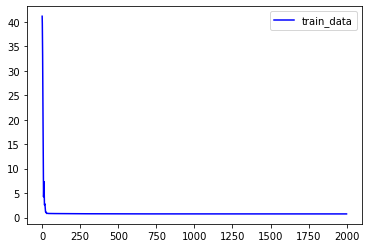

In [121]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(range(len(loss_data_train)),loss_data_train,c="blue",label= "train_data")
plt.legend()
plt.show()

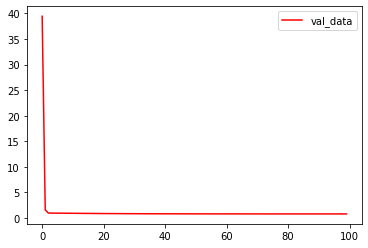

In [122]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(range(len(loss_data_val)),loss_data_val,c="red",label= "val_data")
plt.legend()
plt.show()

In [123]:
y_val = net(X_val_tensor.unsqueeze(1)) 

In [124]:
y_val = y_val.squeeze().detach().numpy()

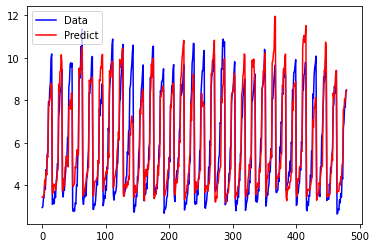

In [125]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(range(len(Y_val)),Y_val,c="blue",label= "Data")
plt.plot(range(len(y_val)),y_val,c="red",label = "Predict")
plt.legend()
plt.show()

In [126]:
y_val.shape

(480,)

In [127]:
path = './val_data_60.csv'

In [128]:
pd_test = pd.read_csv(path, encoding='gbk')

In [129]:
X_test = pd_test[['mean',  'sd', 'min', 'max', '10th', '25th', '50th', '75th','90th']]
Y_test = pd_test[['MET']]
X_test = np.array(X_test)
Y_test = np.array(Y_test)

In [130]:
X_test = scaler.transform(X_test)

In [131]:
X_test_tensor = torch.from_numpy(X_test).float() 
Y_test_tensor = torch.from_numpy(Y_test).float()

In [132]:
test_data = X_test_tensor.unsqueeze(1)
output_predict = net(test_data) 

In [133]:
output_predict = output_predict.squeeze().detach().numpy()

In [137]:
pd_test['model_pred'] = output_predict

In [138]:
pd_test.to_csv('val_model_pred.csv')

In [135]:
y_val_array = []
for item in y_val:
    y_val_array.append(item)

Y_val_array = []
for item in Y_val:
    Y_val_array.append(float(item))   
    
    
m=MSE(Y_val_array,y_val_array)     
r = stats.pearsonr(y_val_array,Y_val_array) 
t=time.strftime("%Y-%m-%d %H:%M:%S",time.localtime())
NN_struct="{0}、{1}、{2}".format(d1,d2,d3)
print (m)
print (r)
print (NN_struct)

path='performance.csv'
csvfile= open(path, 'a', newline='') 
if os.path.getsize(path)!=0:
    writer = csv.writer(csvfile)
    row=[t,freq,NN_struct,str(m),str(r)]  
    writer.writerow(row)
    csvfile.close()  
else:
    writer = csv.writer(csvfile)
    row0 = [u'time', u'frequency（s）', u'structure', u'MSE', u'pearson']  
    writer.writerow(row0)
    row=[t,freq,NN_struct,str(m),str(r)]  
    writer.writerow(row)
    csvfile.close()    

0.8158695476703729
(0.9349455321497474, 3.007087825475138e-217)
9、8、1
